# Stroke Prediction Analysis for Government Awareness Campaign

## Introduction
In this notebook, we'll use the healthcare stroke dataset from Kaggle [more info about dataset here] to discern the factors that increase a person's likelihood of experiencing a stroke. We will perform [xyz models] to perform an inference analysis on the dataset. 

## Import libraries

In [59]:
import pandas as pd
import numpy as np
np.random.seed(42)
from pandas import get_dummies
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold,\
cross_val_score, cross_validate, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc,\
classification_report, make_scorer, recall_score, mean_squared_error
from sklearn.metrics import roc_auc_score as ras
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier,\
ExtraTreesClassifier, VotingClassifier, StackingRegressor
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder,\
StandardScaler, MinMaxScaler, normalize
from imblearn.over_sampling import SMOTE, RandomOverSampler
import warnings
warnings.filterwarnings('ignore')

## Importing and previewing the dataset

In [60]:
df = pd.read_csv("healthcare-dataset-stroke-data.csv")
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


Before we start, we'll drop the id column, as that provides no value to our analysis. 

In [61]:
df.drop("id", axis=1, inplace=True)

In total, there are 10 predictors, and one outcome variable, stroke - 1 for yes and 0 for no.

The 10 predictors are:

- `gender`: Female, Male 

- `age`: Continuous

- `hypertension`: 0, 1

- `heart_disease`: 0, 1

- `ever_married`: Yes, No

- `work_type`: Private, Self-employed, children, Govt_job, Never_worked

- `Residence_type`: Urban, Rural

- `avg_glucose_level`: Continuous

- `bmi`: Continuous, including some NaN values

- `smoking_status`: never smoked, Unknown, formerly smoked, smokes


We'll start by encoding the categorical data. Since the categorical columns are nominal, meaning the categories are not hierarchical, we'll use one-hot-encoding. After encoding the categorical columns, we'll address the NaN values in the bmi column by using simple_imputer to replace null values with the predicted K nearest neighbor (KNN) value. 

In [62]:
df.dtypes

gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

In [63]:
df["gender"].value_counts()

Female    2994
Male      2115
Other        1
Name: gender, dtype: int64

It doesn't make sense to create a new category for "Other" since only one person identified as that, so we'll drop it. 

In [64]:
# LabelEncoder
df = df[df["gender"]!="Other"]
df["gender"].value_counts()

Female    2994
Male      2115
Name: gender, dtype: int64

In [65]:
df.shape

(5109, 11)

(array([1025., 1291., 1565., 1228.]),
 array([8.000e-02, 2.056e+01, 4.104e+01, 6.152e+01, 8.200e+01]),
 <BarContainer object of 4 artists>)

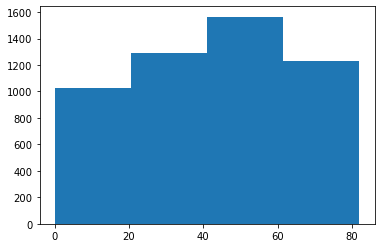

In [66]:
plt.hist(df["age"], bins=4)

In [67]:
df["age"].describe()

count    5109.000000
mean       43.229986
std        22.613575
min         0.080000
25%        25.000000
50%        45.000000
75%        61.000000
max        82.000000
Name: age, dtype: float64

In [68]:
# df.drop("age", axis=1, inplace=True)

In [69]:
#creating a data frame with only age and stroke data
age_stroke = df[["age", "stroke"]]
age_stroke.head()

,age,stroke
0,67.0,1
1,61.0,1
2,80.0,1
3,49.0,1
4,79.0,1


In [70]:
#we are going to split the data into age ranges 0-20,21-40,41-60,61 and up

In [71]:
def assign_category(age):
    if age >= 61:
        return '61 and up'
    elif age >= 41:
        return '41 - 60'
    elif age >= 21:
        return '21 - 40'
    else:
        return '0-20'

# Group rows based on 'age' column and assign categories
age_stroke['Category'] = age_stroke['age'].apply(assign_category)
df['age'] = df['age'].apply(assign_category)
df

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,61 and up,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61 and up,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,61 and up,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,41 - 60,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,61 and up,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...
5105,Female,61 and up,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,Female,61 and up,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,Female,21 - 40,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,Male,41 - 60,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


In [72]:
#changed the column name age to age_range
df.rename(columns={'age': 'age_range'}, inplace=True)
df

,gender,age_range,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,61 and up,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61 and up,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,61 and up,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,41 - 60,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,61 and up,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...
5105,Female,61 and up,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,Female,61 and up,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,Female,21 - 40,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,Male,41 - 60,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


In [73]:
#we wanted to count how many strokes there were per age group
stroke_counts = age_stroke.groupby('Category')['stroke'].sum()

stroke_counts = stroke_counts.reset_index()
stroke_counts

,Category,stroke
0,0-20,2
1,21 - 40,6
2,41 - 60,64
3,61 and up,177


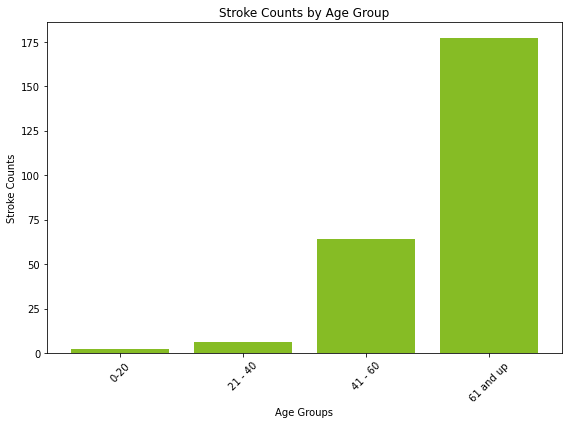

In [74]:
#creating visulization(bar chart) of the age and stroke data
plt.figure(figsize=(8, 6))
plt.bar(stroke_counts['Category'], stroke_counts['stroke'], color= '#86BC25')
plt.xlabel('Age Groups')
plt.ylabel('Stroke Counts')
plt.title('Stroke Counts by Age Group')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('model_selection1')
plt.show()


In [75]:
# OHE
df["ever_married"].value_counts()

Yes    3353
No     1756
Name: ever_married, dtype: int64

In [76]:
# OHE
df["Residence_type"].value_counts()

Urban    2596
Rural    2513
Name: Residence_type, dtype: int64

In [77]:
# OHE
df["work_type"].value_counts()

Private          2924
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: work_type, dtype: int64

In [78]:
# OHE
df["smoking_status"].value_counts()

never smoked       1892
Unknown            1544
formerly smoked     884
smokes              789
Name: smoking_status, dtype: int64

In [79]:
df.select_dtypes(include=['object']).head()

,gender,age_range,ever_married,work_type,Residence_type,smoking_status
0,Male,61 and up,Yes,Private,Urban,formerly smoked
1,Female,61 and up,Yes,Self-employed,Rural,never smoked
2,Male,61 and up,Yes,Private,Rural,never smoked
3,Female,41 - 60,Yes,Private,Urban,smokes
4,Female,61 and up,Yes,Self-employed,Rural,never smoked


In [80]:
#pd.get_dummies(data, prefix = "work_type", drop_first=True, dtype=int)
categorical = df.select_dtypes(include=['object'])

ohe = OneHotEncoder(drop='first')
ohe.fit(categorical)
categorical_encoded = pd.DataFrame(ohe.transform(categorical).todense(),
                               columns=ohe.get_feature_names())

# Removing 'x0_', 'x1_', etc. prefixes from column names
categorical_encoded.columns = categorical_encoded.columns.str.replace(r'^x\d_', '', regex=True)
categorical_encoded

,Male,21 - 40,41 - 60,61 and up,Yes,Never_worked,Private,Self-employed,children,Urban,formerly smoked,never smoked,smokes
0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
1,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
4,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5104,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
5105,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
5106,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
5107,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [81]:
df_numeric = df.select_dtypes("number")
df_numeric.head()

,hypertension,heart_disease,avg_glucose_level,bmi,stroke
0,0,1,228.69,36.6,1
1,0,0,202.21,NaN,1
2,0,1,105.92,32.5,1
3,0,0,171.23,34.4,1
4,1,0,174.12,24.0,1


In [82]:
# df_numeric.drop("stroke", axis=1, inplace=True)

In [83]:
df_new = pd.concat([categorical_encoded.reset_index(), df_numeric.reset_index()], axis=1)
df_new.drop("index", axis=1, inplace=True)
df_new.head()

,Male,21 - 40,41 - 60,61 and up,Yes,Never_worked,Private,Self-employed,children,Urban,formerly smoked,never smoked,smokes,hypertension,heart_disease,avg_glucose_level,bmi,stroke
0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0,1,228.69,36.6,1
1,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0,0,202.21,NaN,1
2,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0,1,105.92,32.5,1
3,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0,0,171.23,34.4,1
4,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1,0,174.12,24.0,1


Now that the dataset is all numeric, we can use the KNNImputer tool to replace the null values in the BMI column. This should give us a better result than simply using the mean, median, or most frequent.

In [84]:
# Split the data into features and target
X = df_new.drop('bmi', axis=1)
y = df_new['bmi']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

##Commented out to save time--------------
## Set up the KNNImputer and grid search
#param_grid = {'n_neighbors': [1, 2, 3, 4, 5]}
#knn_imputer = KNNImputer()
#grid_search = GridSearchCV(knn_imputer, param_grid, cv=5, scoring='neg_mean_squared_error')

##Fit the grid search to the training data
#grid_search.fit(X_train, y_train)

##Get the best parameters, including the best number of neighbors (k)
#best_params = grid_search.best_params_
#best_neighbors = best_params['n_neighbors']

##Print the best parameters
#print("Best Parameters:")
#print(best_params)

In [85]:
knn_imputer = KNNImputer(n_neighbors=1)  # Adjust the number of neighbors as needed

# Impute missing values in the DataFrame
df_imputed = pd.DataFrame(knn_imputer.fit_transform(df_new), columns=df_new.columns)

In [86]:
df_imputed.isnull().values.any()

False

In [87]:
df_imputed.shape

(5109, 18)

The last thing we should do is check for multicollinearity. If two features are too correlated, it will be difficult to determine which feature is impacting our results. Below, we check to see if any columns are <70% correlated.

In [88]:
# Handling multicollinearity

columns = list(df_imputed.columns)
for col in columns:
    if col == 'stroke':
        continue

    filtered_columns = [col]
    for col1 in df_imputed.columns:
        if((col == col1) | (col == 'stroke')):
            continue

        val = df_imputed[col].corr(df_imputed[col1])

        if val > 0.7:
            # If the correlation between the two
            # features is more than 0.7 remove
            columns.remove(col1)
            continue
        else:
            filtered_columns.append(col1)

    # After each iteration filter out the columns
    # which are not highly correlated features.
    df = df_imputed[filtered_columns]
df.shape

(5109, 18)

Our dimensions remain the same which means there were no feature correlations above our 70% threshold. We can begin training our models.

## Model Training

Now that the dataset is cleaned, we can begin comparing the performance of various models. Since this is a binary classification problem, we'll try the following models:
- Logistic regression
- K Nearest Neighbor classifier
- Decision Tree Classifier
- Random Forest Classifier
- XGBoost
- Support vector machine (SVM)

We'll also compare SMOTE to RandomOverSampler on our minority class and create a more balanced dataset for our target variable. This should help our model better predict when someone has actually experienced a stroke.

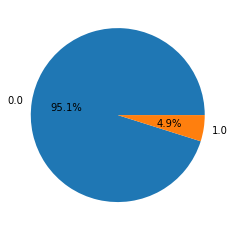

In [89]:
target_dist = df['stroke'].value_counts()
plt.pie(target_dist.values,
        labels = target_dist.index,
        autopct='%1.1f%%')
plt.show()

In [90]:
features = df.drop('stroke', axis=1)
target = df['stroke']
 
X_train, X_val, Y_train, Y_val = train_test_split(features, target, test_size=0.2, stratify=target, random_state=42)

X_train.shape, X_val.shape

((4087, 17), (1022, 17))

### Model Selection

In [91]:
recall_scores= []

smote = SMOTE(random_state=0)
ros = RandomOverSampler(sampling_strategy='minority', random_state=0)

oversampling_techniques = [smote, ros]

for technique in oversampling_techniques:
    
    print(f'{technique} : ')
    print("___________________________________________")
    
    X_resampled, Y_resampled = technique.fit_resample(X_train, Y_train)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_resampled)
    X_val_scaled = scaler.transform(X_val)

    X_train_scaled.shape, Y_resampled.shape


    models = [LogisticRegression(), 
              DecisionTreeClassifier(), 
              RandomForestClassifier(), 
              KNeighborsClassifier(), 
              SVC(kernel='rbf', probability=True),
              XGBClassifier()]

    for model in models:
        model.fit(X_train_scaled, Y_resampled)

        print(f'{model} : ')

        train_preds_proba = model.predict_proba(X_train_scaled)[:, 1]
        print('Training ROC AUC Score : ', ras(Y_resampled, train_preds_proba))

        val_preds_proba = model.predict_proba(X_val_scaled)[:, 1]
        print('Validation ROC AUC Score : ', ras(Y_val, val_preds_proba))
        print()

        train_preds = model.predict(X_train_scaled)
        print('Training Accuracy : ', ras(Y_resampled, train_preds))

        val_preds = model.predict(X_val_scaled)
        print('Validation Accuracy : ', ras(Y_val, val_preds))
        print()

        conf_matrix = confusion_matrix(Y_val, val_preds, normalize='true')

        print("Confusion Matrix:")
        print(conf_matrix)

        test_recall = recall_score(Y_val, val_preds)
        recall_scores.append(test_recall)
        print(f"Recall: {test_recall}")

        print("")
        print("----------------------")
        print("")

SMOTE(random_state=0) : 
___________________________________________
LogisticRegression() : 
Training ROC AUC Score :  0.836725246193839
Validation ROC AUC Score :  0.8036419753086419

Training Accuracy :  0.7844650205761317
Validation Accuracy :  0.7487654320987654

Confusion Matrix:
[[0.69753086 0.30246914]
 [0.2        0.8       ]]
Recall: 0.8

----------------------

DecisionTreeClassifier() : 
Training ROC AUC Score :  1.0
Validation ROC AUC Score :  0.5486213991769547

Training Accuracy :  1.0
Validation Accuracy :  0.5486213991769547

Confusion Matrix:
[[0.9372428 0.0627572]
 [0.84      0.16     ]]
Recall: 0.16

----------------------

RandomForestClassifier() : 
Training ROC AUC Score :  1.0
Validation ROC AUC Score :  0.6933333333333334

Training Accuracy :  1.0
Validation Accuracy :  0.5153703703703704

Confusion Matrix:
[[0.99074074 0.00925926]
 [0.96       0.04      ]]
Recall: 0.04

----------------------

KNeighborsClassifier() : 
Training ROC AUC Score :  0.99741187535987

In [92]:
# training and validation accuracy with the recall for each model
data = {
    'Logistic Regression': [78.5, 74.8, 80],
    'Decision Tree Classifier': [100, 54.9, 16],
    'Random Forest Classifier': [100, 51.5, 4],
    'KNeighbors Classifier': [95.7, 64.4, 40],
    'SVC (probability=True)': [94.1, 57.5, 20],
    'XGBClassifier': [99.4, 53.2, 8]
}

# Creating a DataFrame
df_recall = df_recall.rename(index={0: 'Training Accuracy', 1: 'Validation Accuracy', 2: 'Recall %'})

# Displaying the modified DataFrame
df_recall

,Logistic Regression,Decision Tree Classifier,Random Forest Classifier,KNeighbors Classifier,SVC (probability=True),XGBClassifier
Training Accuracy,78.5,100.0,100.0,95.7,94.1,99.4
Validation Accuracy,74.8,54.9,51.5,64.4,57.5,53.2
Recall %,80.0,16.0,4.0,40.0,20.0,8.0


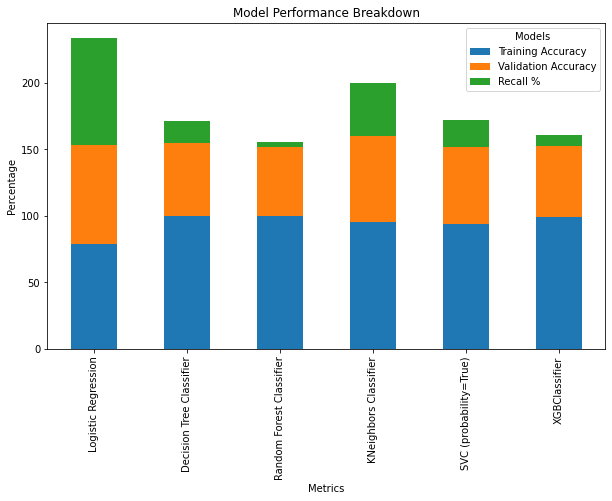

In [93]:
df_recall.transpose().plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Model Performance Breakdown')
plt.xlabel('Metrics')
plt.ylabel('Percentage')
plt.legend(title='Models', bbox_to_anchor=(1, 1))
plt.show()

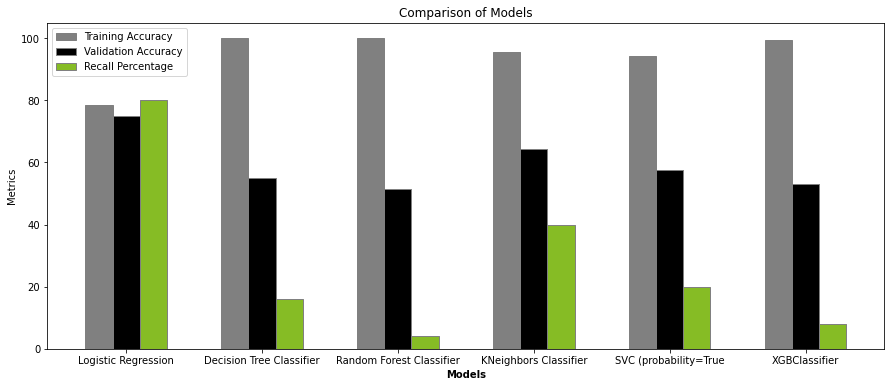

In [94]:
import matplotlib.pyplot as plt
import numpy as np
 
# Sample data
models = ['Logistic Regression', 'Decision Tree Classifier', 'Random Forest Classifier', 'KNeighbors Classifier', 'SVC (probability=True', 'XGBClassifier']
training_accuracy = [78.5,100.0,100.0,95.7,94.1,99.4]
validation_accuracy = [74.8,54.9,51.5,64.4,57.5,53.2]
recall_percentage = [80.0,16.0,4.0,40.0,20.0,8.0]
 
# Set up the figure and axes
fig, ax = plt.subplots(figsize=(15, 6))
 
# Set the width of the bars
bar_width = 0.2
 
# Set the positions of the bars on X-axis
r1 = np.arange(len(models))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
 
# Plot the data
plt.bar(r1, training_accuracy, color='grey', width=bar_width, edgecolor='grey', label='Training Accuracy')
plt.bar(r2, validation_accuracy, color='black', width=bar_width, edgecolor='grey', label='Validation Accuracy')
plt.bar(r3, recall_percentage, color='#86BC25', width=bar_width, edgecolor='grey', label='Recall Percentage')
 
# Add labels and title
plt.xlabel('Models', fontweight='bold')
plt.xticks([r + bar_width for r in range(len(models))], models)
plt.ylabel('Metrics')
plt.title('Comparison of Models')
 
# Add legend
plt.legend()
 
plt.savefig('model_selection')
# Show the plot
plt.show()


Our logistic regression model using SMOTE seems to be fitting the best with regard to **accuracy (78.5% training, 76.9% validation)** and **recall (80%)** so we'll use that model. 

In [95]:
X_resampled, Y_resampled = smote.fit_resample(X_train, Y_train)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_resampled)
X_val_scaled = scaler.transform(X_val)

X_train_scaled.shape, Y_resampled.shape

((7776, 17), (7776,))

## Picking the best model

Given our business problem -- performing inferential statistics on stroke patients for a government awareness campaign -- we are mostly interested in patients **who HAVE experienced a stroke**. Therefore, the best model for us appears to be the **logistic regression model**. Let's finally tune the model using grid_search to get the optimal parameters for recall, while maintaining a good accuracy score. 

In [96]:
# Define the parameter grid
param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'max_iter': [100, 500, 1000],
    'class_weight': [None, 'balanced']
}

# Define the scoring metrics (recall and accuracy)
scoring = {
    'Accuracy': make_scorer(accuracy_score),
    'Recall': make_scorer(recall_score)
}

# Create the GridSearchCV object
lr_model = LogisticRegression() 
grid_search = GridSearchCV(
    estimator=lr_model,
    param_grid=param_grid,
    scoring=scoring,
    refit='Recall',  # Refit based on Recall
    cv=10,  # Number of cross-validation folds
)

# Fit the grid search to the data
grid_search.fit(X_train_scaled, Y_resampled)

# Print the best parameters and corresponding scores for both accuracy and recall
print("Best Parameters (Recall):", grid_search.best_params_)
print("Best Recall Score:", grid_search.best_score_)

# Access the accuracy results
accuracy_results = grid_search.cv_results_['mean_test_Accuracy']
print("Best Parameters (Accuracy):", param_grid["C"][accuracy_results.argmax()])
print("Best Accuracy Score:", accuracy_results.max())

# Evaluate the model on the test set using the best parameters for recall
best_model_recall = grid_search.best_estimator_
y_pred_recall = best_model_recall.predict(X_val_scaled)
test_recall = recall_score(Y_val, y_pred_recall)
print("Test Recall Score:", test_recall)

# Evaluate the model on the test set using the best parameters for accuracy
best_model_accuracy = grid_search.best_estimator_
y_pred_accuracy = best_model_accuracy.predict(X_val_scaled)
test_accuracy = accuracy_score(Y_val, y_pred_accuracy)
print("Test Accuracy Score:", test_accuracy)

Best Parameters (Recall): {'C': 100, 'class_weight': None, 'max_iter': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
Best Recall Score: 0.8618841597540614
Best Parameters (Accuracy): 0.001
Best Accuracy Score: nan
Test Recall Score: 0.8
Test Accuracy Score: 0.7035225048923679


In [97]:
best_model = LogisticRegression(
    penalty='l1',
    C=0.001,
    class_weight=None,
    max_iter=100,
    solver='liblinear',
    random_state=42 
)

# Fit the model to your entire training dataset
best_model.fit(X_train_scaled, Y_resampled)

# using best_recall_model for predictions on new data
y_pred = best_model.predict(X_val_scaled)
y_pred_train = best_model.predict(X_train_scaled)
test_recall = recall_score(Y_val, y_pred)
train_accuracy = accuracy_score(Y_resampled, y_pred_train)
test_accuracy = accuracy_score(Y_val, y_pred)
conf_matrix = confusion_matrix(Y_val, y_pred)

print(f"Recall: {test_recall}")
print(f"Train Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")
print("Confusion Matrix:")
print(conf_matrix)

Recall: 0.76
Train Accuracy: 0.7393261316872428
Test Accuracy: 0.7729941291585127
Confusion Matrix:
[[752 220]
 [ 12  38]]


Tuning our parameters increased our recall by 4% and our model now correctly predicts 84% of the stroke patients, while still predicting a significant amount of non-stroke patients. With this model, we can start learning more about what factors are correlated to strokes.

## Feature importance

In [98]:
# Retrieve the coefficients and feature names
coefficients = best_model.coef_[0]
feature_names = X_train.columns

# Create a DataFrame to display the coefficients and feature names
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients,
    'Odds Ratio': np.exp(coefficients)
})

# Sort the DataFrame by the absolute value of coefficients to highlight the most impactful features
feature_importance_df = feature_importance_df.reindex(feature_importance_df['Coefficient'].abs().sort_values(ascending=False).index)

# Display the feature importance DataFrame
print("Feature Importance:")
feature_importance_df

Feature Importance:


,Feature,Coefficient,Odds Ratio
4,61 and up,0.490857,1.633715
2,21 - 40,-0.032836,0.967698
16,avg_glucose_level,0.000000,1.000000
7,Private,0.000000,1.000000
1,Male,0.000000,1.000000
3,41 - 60,0.000000,1.000000
5,Yes,0.000000,1.000000
6,Never_worked,0.000000,1.000000
8,Self-employed,0.000000,1.000000
15,heart_disease,0.000000,1.000000


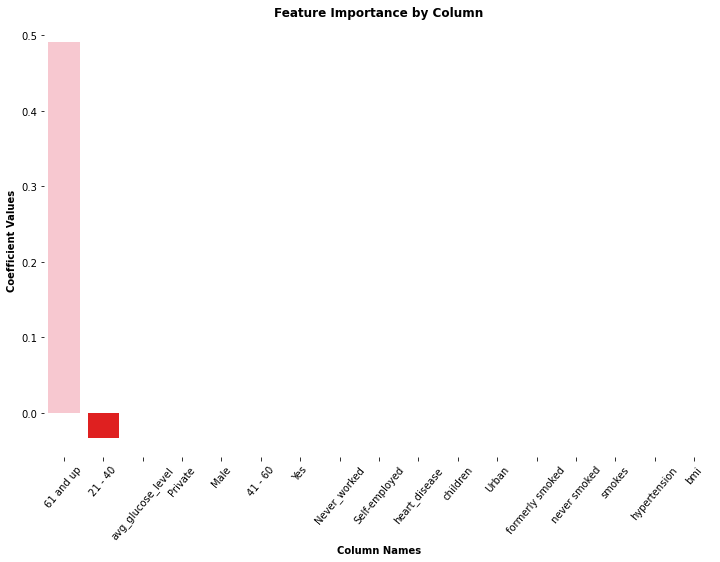

In [99]:
import seaborn as sns

x=feature_importance_df['Feature']
y=feature_importance_df['Coefficient']

fig, ax = plt.subplots(figsize=(12, 8))

colors = ['pink' if _y >=0 else 'red' for _y in y]
ax = sns.barplot(x, y, palette=colors)

ax.set_ylabel("Coefficient Values", fontweight='bold')
ax.set_xlabel("Column Names", fontweight='bold')
ax.set_title("Feature Importance by Column", fontweight='bold')
ax.tick_params (axis='x', labelrotation=50)

sns.despine(ax=ax, bottom=True, left=True)
plt.show()

This is disappointing. Our tuned model is not generalized enough, and only uses the strongest correlated feature, age. Let's go back to the base model. 

In [100]:
lr_model = LogisticRegression()

# Fit the model to your entire training dataset
lr_model.fit(X_train_scaled, Y_resampled)

# using best_recall_model for predictions on new data
y_pred = lr_model.predict(X_val_scaled)
y_pred_train = lr_model.predict(X_train_scaled)
test_recall = recall_score(Y_val, y_pred)
train_accuracy = accuracy_score(Y_resampled, y_pred_train)
test_accuracy = accuracy_score(Y_val, y_pred)
conf_matrix = confusion_matrix(Y_val, y_pred)

print(f"Recall: {test_recall}")
print(f"Train Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")
print("Confusion Matrix:")
print(conf_matrix)

Recall: 0.8
Train Accuracy: 0.7844650205761317
Test Accuracy: 0.7025440313111546
Confusion Matrix:
[[678 294]
 [ 10  40]]


In [101]:
# Retrieve the coefficients and feature names
coefficients = lr_model.coef_[0]
feature_names = X_train.columns

# Create a DataFrame to display the coefficients and feature names
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients,
    'Odds Ratio': np.exp(coefficients)
})

# Sort the DataFrame by the absolute value of coefficients to highlight the most impactful features
feature_importance_df = feature_importance_df.reindex(feature_importance_df['Coefficient'].abs().sort_values(ascending=False).index)

# Display the feature importance DataFrame
print("Feature Importance:")
feature_importance_df

Feature Importance:


,Feature,Coefficient,Odds Ratio
4,61 and up,2.786999,16.232227
3,41 - 60,1.980437,7.245908
2,21 - 40,0.406836,1.502058
14,hypertension,0.289619,1.335919
9,children,0.272185,1.312830
16,avg_glucose_level,0.256964,1.292999
5,Yes,-0.177076,0.837716
6,Never_worked,-0.141297,0.868231
7,Private,0.137072,1.146911
0,bmi,-0.127402,0.880380


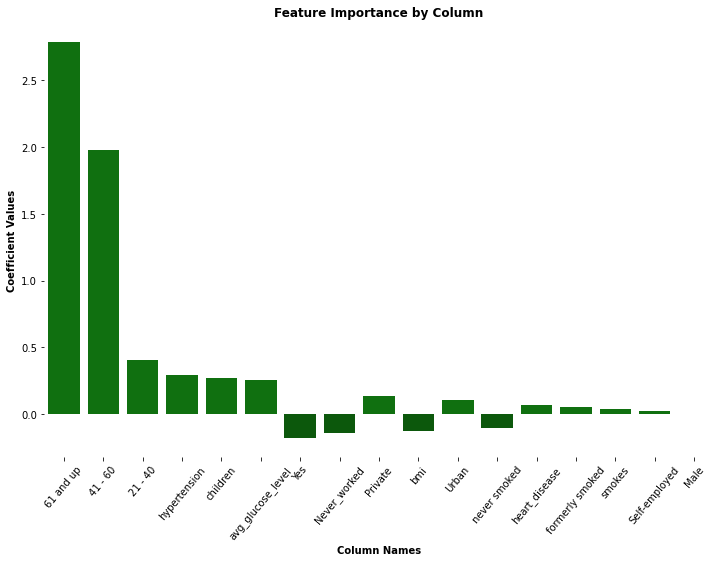

In [102]:
import seaborn as sns

# Extracting data for x-axis (features) and y-axis (coefficients)
x=feature_importance_df['Feature']
y=feature_importance_df['Coefficient']

# Creating a figure and axis objects with specified size
fig, ax = plt.subplots(figsize=(12, 8))

# Assigning colors based on positive or negative coefficients
colors = ['green' if _y >=0 else 'darkgreen' for _y in y]
ax = sns.barplot(x, y, palette=colors)

# Setting labels for y-axis, x-axis, and the plot title
ax.set_ylabel("Coefficient Values", fontweight='bold')
ax.set_xlabel("Column Names", fontweight='bold')
ax.set_title("Feature Importance by Column", fontweight='bold')
ax.tick_params (axis='x', labelrotation=50)

sns.despine(ax=ax, bottom=True, left=True)
plt.show()

In [103]:
# Generating predicted probabilities for the positive class (class 1) using the logistic regression model
val_probs = lr_model.predict_proba(X_val_scaled)[:, 1]
val_probs = pd.DataFrame(val_probs, columns=["predictions"])

In [104]:
# Concatenating X_val and val_probs DataFrames, resetting indexes to align data correctly
df_results = pd.concat([X_val.reset_index(), val_probs.reset_index()], axis=1)

# Dropping the 'index' column that was created during concatenation
df_results.drop("index", axis=1, inplace=True)

# Grouping the DataFrame by 'gender_Male' and 'ever_married_Yes', then calculating mean for each
df_results.groupby(["Male", "Yes"]).mean()

bmi   21 - 40   41 - 60  61 and up  Never_worked   Private  \
Male Yes                                                                     
0.0  0.0  25.895098  0.333333  0.098039   0.058824      0.014706  0.549020   
     1.0  30.594402  0.229008  0.414758   0.353690      0.000000  0.608142   
1.0  0.0  25.050617  0.222222  0.111111   0.049383      0.018519  0.444444   
     1.0  31.260456  0.186312  0.437262   0.376426      0.000000  0.673004   

          Self-employed  children     Urban  formerly smoked  never smoked  \
Male Yes                                                                     
0.0  0.0       0.049020  0.318627  0.563725         0.068627      0.328431   
     1.0       0.211196  0.000000  0.508906         0.190840      0.450382   
1.0  0.0       0.080247  0.413580  0.561728         0.104938      0.228395   
     1.0       0.186312  0.000000  0.517110         0.239544      0.346008   

            smokes  hypertension  heart_disease  avg_glucose_level  \
Male Yes                                                             
0.0  0.0  0.147059      0.039216       0.014706          97.474216   
     1.0  0.185751      0.127226       0.033079         110.121476   
1.0  0.0  0.098765      0.030864       0.024691          98.058704   
     1.0  0.205323      0.182510       0.091255         115.703764   

          predictions  
Male Yes               
0.0  0.0     0.123880  
     1.0     0.434487  
1.0  0.0     0.119793  
     1.0     0.481761

In [105]:
#df_results['61 and up'].min(), df_results['61 and up'].max()

In [106]:
#plt.hist(df_results["61 and up"])

We could also try dropping age from our dataset to increase the importance of the other features. 